베스트셀러_최종버전12.csv
비베스트셀러_최종버전11.csv

# 가설

1. 도서평가점수와 각 플랫폼의 베스트셀러 여부는 유의미한 관계가 없다
2. 베스트셀러 여부에 저자는 관계가 없다
3. 특정 플랫폼에서만 베스트셀러일 경우 도서평가점수가 높다
4. 2개 이상의 플랫폼에서 베스트셀러로 등재된 도서일 경우 평가점수가 낮다
5. 소설, 문학 장르는 타 장르보다 도서평가점수가 낮다
6. 알라딘은 중복으로 베스트셀러가 등재되어 있는 도서가 플랫폼 중 가장 적다
7. 영풍에서 베스트셀러가 된 도서는 매우 인기있는 도서여서 모든 플랫폼에서 베스트셀러일 확률이 높다

1. 도서평가점수와 각 플랫폼의 베스트셀러 여부는 유의미한 관계가 없다

In [10]:
import pandas as pd
df = pd.read_csv('베스트셀러_최종버전12.csv')
df1 = pd.read_csv('비베스트셀러_최종버전11.csv')

In [15]:
test = pd.concat([df, df1])

In [17]:
from scipy.stats import shapiro, levene
import pandas as pd

platforms = ['kyobo', 'aladin', 'yes24', 'yp']
results = []

for p in platforms:
    best_col = f'{p}_best'
    score_col = f'{p}_score'
    
    group1 = test[test[best_col] == 1][score_col].dropna()
    group0 = test[test[best_col] == 0][score_col].dropna()
    
    # 정규성 (Shapiro-Wilk)
    p_normal_1 = shapiro(group1)[1]
    p_normal_0 = shapiro(group0)[1]
    
    # 등분산성 (Levene)
    p_levene = levene(group1, group0)[1]
    
    results.append({
        '플랫폼': p,
        '정규성_p (베스트셀러)': round(p_normal_1, 4),
        '정규성_p (비베스트셀러)': round(p_normal_0, 4),
        '등분산성_p': round(p_levene, 4)
    })

# 결과 보기
result_df = pd.DataFrame(results)
print(result_df)


      플랫폼  정규성_p (베스트셀러)  정규성_p (비베스트셀러)  등분산성_p
0   kyobo            0.0             0.0     0.0
1  aladin            0.0             0.0     0.0
2   yes24            0.0             0.0     0.0
3      yp            0.0             0.0     0.0


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7551.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 6681.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8248.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 8680.
  res = hypotes

4개 플랫폼 모두 정규성(p=0.000) 및 등분산성(p=0.000)을 만족하지 않으므로,
krskal-wallis 검정을 통해 두 집단의 도서 평가점수 차이를 분석

In [18]:
from scipy.stats import kruskal
import pandas as pd

platforms = ['kyobo', 'aladin', 'yes24', 'yp']
results = []

for p in platforms:
    best_col = f'{p}_best'
    score_col = f'{p}_score'
    
    group0 = test[test[best_col] == 0][score_col].dropna()
    group1 = test[test[best_col] == 1][score_col].dropna()
    
    stat, p_value = kruskal(group0, group1)
    
    results.append({
        '플랫폼': p,
        'p-value': round(p_value, 4),
        '유의미한 차이 여부 (p<0.05)': '✅ Yes' if p_value < 0.05 else '❌ No'
    })

result_df = pd.DataFrame(results)
print(result_df)


      플랫폼  p-value 유의미한 차이 여부 (p<0.05)
0   kyobo      0.0               ✅ Yes
1  aladin      0.0               ✅ Yes
2   yes24      0.0               ✅ Yes
3      yp      0.0               ✅ Yes


네 플랫폼 모두 p값이 0.05보다 작기에 귀무가설을 기각
즉, 도서평가점수와 각 플랫폼간의 베트스셀러 여부는 유의미한 관계가 있다

2. 베스트셀러 여부에 저자는 관계가 없다
범주형 데이터간의 분석이기에 정규성, 등분산성을 파악하지 않고 카이제곱 검정 진행

In [20]:
import pandas as pd
from scipy.stats import chi2_contingency

# 분석 대상 플랫폼 컬럼 리스트
platforms = ['kyobo_best', 'aladin_best', 'yes24_best', 'yp_best']

# 결과 저장용
results = []

for platform in platforms:
    print(f"\n===== {platform} vs AUTHOR =====")
    
    # 교차표 생성
    cross_tab = pd.crosstab(test['AUTHOR'], test[platform])
    
    # 너무 희귀한 저자 제거 (분석 안정성을 위해, 1권만 낸 저자 제거)
    cross_tab = cross_tab[cross_tab.sum(axis=1) > 1]
    
    # 카이제곱 검정
    chi2, p, dof, expected = chi2_contingency(cross_tab)
    
    # 결과 출력
    print(f"Chi-squared statistic: {chi2:.4f}")
    print(f"p-value: {p:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p < 0.05:
        print("✅ 저자와 베스트셀러 여부는 유의미한 관계가 있습니다. (귀무가설 기각)")
    else:
        print("❌ 저자와 베스트셀러 여부는 유의미한 관계가 없습니다. (귀무가설 채택)")
    
    # 결과 저장
    results.append({
        '플랫폼': platform,
        '카이제곱통계량': chi2,
        'p-value': p,
        '자유도': dof,
        '유의미한 관계': p < 0.05
    })

# 결과 요약 DataFrame
summary = pd.DataFrame(results)
print("\n=== 요약 결과 ===")
print(summary)



===== kyobo_best vs AUTHOR =====
Chi-squared statistic: 2119.2820
p-value: 0.0000
Degrees of freedom: 1244
✅ 저자와 베스트셀러 여부는 유의미한 관계가 있습니다. (귀무가설 기각)

===== aladin_best vs AUTHOR =====
Chi-squared statistic: 2055.9031
p-value: 0.0000
Degrees of freedom: 1244
✅ 저자와 베스트셀러 여부는 유의미한 관계가 있습니다. (귀무가설 기각)

===== yes24_best vs AUTHOR =====
Chi-squared statistic: 1911.1122
p-value: 0.0000
Degrees of freedom: 1244
✅ 저자와 베스트셀러 여부는 유의미한 관계가 있습니다. (귀무가설 기각)

===== yp_best vs AUTHOR =====
Chi-squared statistic: 2209.0982
p-value: 0.0000
Degrees of freedom: 1244
✅ 저자와 베스트셀러 여부는 유의미한 관계가 있습니다. (귀무가설 기각)

=== 요약 결과 ===
           플랫폼      카이제곱통계량       p-value   자유도  유의미한 관계
0   kyobo_best  2119.281992  1.586019e-48  1244     True
1  aladin_best  2055.903090  6.215094e-43  1244     True
2   yes24_best  1911.112241  3.900034e-31  1244     True
3      yp_best  2209.098218  7.365786e-57  1244     True


<Figure size 1400x800 with 0 Axes>

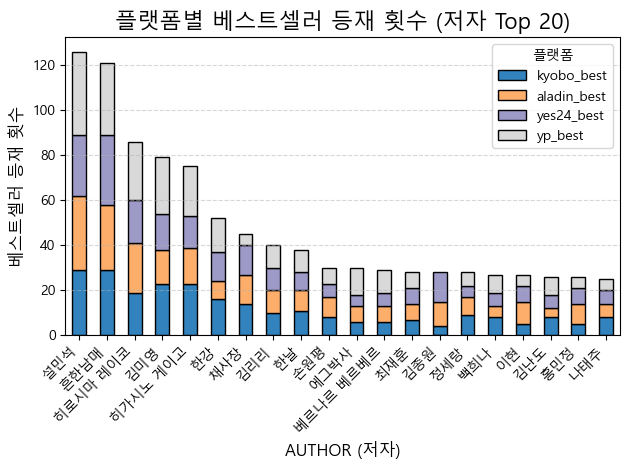

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
# 1. 분석할 베스트셀러 열 목록
platforms = ['kyobo_best', 'aladin_best', 'yes24_best', 'yp_best']

# 2. 저자별로 플랫폼별 베스트셀러 여부 합산 (총 등재 횟수)
author_best_counts = test.groupby('AUTHOR')[platforms].sum()

# 3. 총합 열 추가 (전체 플랫폼에서 등재된 횟수)
author_best_counts['total_best'] = author_best_counts.sum(axis=1)

# 4. Top 20 저자 추출
top20_authors = author_best_counts.sort_values(by='total_best', ascending=False).head(20)

# 5. 시각화 (stacked bar chart)
top20_authors_sorted = top20_authors[platforms]  # 플랫폼별 등재 횟수만 사용

plt.figure(figsize=(14, 8))
top20_authors_sorted.plot(kind='bar', stacked=True, colormap='tab20c', edgecolor='black')

plt.title('플랫폼별 베스트셀러 등재 횟수 (저자 Top 20)', fontsize=16)
plt.xlabel('AUTHOR (저자)', fontsize=12)
plt.ylabel('베스트셀러 등재 횟수', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='플랫폼')
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


모든 플랫폼에서 p값이 0.05보다 작기에 귀무가설 기각
즉, 베스트셀러 여부에 저자는 관계가 있다

3. 특정 플랫폼에서만 베스트셀러일 경우 도서평가점수가 높다

In [23]:
from scipy.stats import shapiro, levene
import pandas as pd

platforms = ['kyobo', 'aladin', 'yes24', 'yp']

for platform in platforms:
    print(f"\n======= [{platform.upper()} 플랫폼 정규성 및 등분산성 검정] =======")
    
    best_col = f"{platform}_best"
    score_col = f"{platform}_score"
    
    only_best = test[
        (test[best_col] == 1) &
        (test[[p + '_best' for p in platforms if p != platform]] == 0).all(axis=1)
    ]
    non_best = test[
        (test[[p + '_best' for p in platforms]] == 0).all(axis=1)
    ]
    
    only_scores = only_best[score_col].dropna()
    non_scores = non_best[score_col].dropna()
    
    print(f" - 샘플 수: only_best = {len(only_scores)}, non_best = {len(non_scores)}")
    
    if len(only_scores) < 5 or len(non_scores) < 5:
        print("⚠️ 샘플 수 부족으로 검정 생략")
        continue
    
    # 정규성 검정
    shapiro_only = shapiro(only_scores)
    shapiro_non = shapiro(non_scores)
    
    # 등분산성 검정
    levene_test = levene(only_scores, non_scores)
    
    print(f" - 정규성 p-value (only_best): {shapiro_only.pvalue:.4f}")
    print(f" - 정규성 p-value (non_best): {shapiro_non.pvalue:.4f}")
    print(f" - 등분산성 p-value: {levene_test.pvalue:.4f}")



======= [KYOBO 플랫폼 정규성 및 등분산성 검정] =======
 - 샘플 수: only_best = 603, non_best = 5143
 - 정규성 p-value (only_best): 0.0000
 - 정규성 p-value (non_best): 0.0000
 - 등분산성 p-value: 0.0000

======= [ALADIN 플랫폼 정규성 및 등분산성 검정] =======
 - 샘플 수: only_best = 1592, non_best = 5143
 - 정규성 p-value (only_best): 0.0000
 - 정규성 p-value (non_best): 0.0000
 - 등분산성 p-value: 0.0000

======= [YES24 플랫폼 정규성 및 등분산성 검정] =======
 - 샘플 수: only_best = 149, non_best = 5143
 - 정규성 p-value (only_best): 0.0000
 - 정규성 p-value (non_best): 0.0000
 - 등분산성 p-value: 0.0000

======= [YP 플랫폼 정규성 및 등분산성 검정] =======
 - 샘플 수: only_best = 263, non_best = 5143
 - 정규성 p-value (only_best): 0.0000
 - 정규성 p-value (non_best): 0.0000
 - 등분산성 p-value: 0.0000


c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5143.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5143.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5143.
  res = hypotest_fun_out(*samples, **kwds)
c:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5143.
  res = hypotes

네 플랫폼 베스트셀러 여부와 평가점수의 정규성, 등분산성의 p값이 0.05보다 작음
베스트셀러와 비베스트셀러 도서간의 차이를 파악하고 더 높은지를 파악해야하기에 Mann-Whitney U 검정

In [30]:
from scipy.stats import mannwhitneyu

platforms = ['kyobo', 'aladin', 'yes24', 'yp']

for platform in platforms:
    print(f"\n======= [{platform.upper()} 플랫폼 Mann-Whitney U 검정] =======")

    best_col = f"{platform}_best"
    score_col = f"{platform}_score"

    only_best = test[
        (test[best_col] == 1) &
        (test[[p + '_best' for p in platforms if p != platform]] == 0).all(axis=1)
    ]
    non_best = test[
        (test[[p + '_best' for p in platforms]] == 0).all(axis=1)
    ]

    only_scores = only_best[score_col].dropna()
    non_scores = non_best[score_col].dropna()

    print(f" - 샘플 수: only_best = {len(only_scores)}, non_best = {len(non_scores)}")

    if len(only_scores) < 5 or len(non_scores) < 5:
        print("⚠️ 샘플 수 부족으로 검정 생략")
        continue

    # Mann-Whitney U 검정, alternative='greater' => only_best 점수가 더 크다는 가설 검정
    stat, p_value = mannwhitneyu(only_scores, non_scores, alternative='greater')

    print(f" - Mann-Whitney U 통계량: {stat:.4f}")
    print(f" - p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 높다고 할 수 있습니다. (귀무가설 기각)")
    else:
        print("❌ 평가점수가 더 높다는 통계적 증거가 부족합니다. (귀무가설 채택)")



======= [KYOBO 플랫폼 Mann-Whitney U 검정] =======
 - 샘플 수: only_best = 603, non_best = 5143
 - Mann-Whitney U 통계량: 2849117.5000
 - p-value: 0.0000
✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 높다고 할 수 있습니다. (귀무가설 기각)

======= [ALADIN 플랫폼 Mann-Whitney U 검정] =======
 - 샘플 수: only_best = 1592, non_best = 5143
 - Mann-Whitney U 통계량: 6685744.5000
 - p-value: 0.0000
✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 높다고 할 수 있습니다. (귀무가설 기각)

======= [YES24 플랫폼 Mann-Whitney U 검정] =======
 - 샘플 수: only_best = 149, non_best = 5143
 - Mann-Whitney U 통계량: 470364.0000
 - p-value: 0.0000
✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 높다고 할 수 있습니다. (귀무가설 기각)

======= [YP 플랫폼 Mann-Whitney U 검정] =======
 - 샘플 수: only_best = 263, non_best = 5143
 - Mann-Whitney U 통계량: 817015.5000
 - p-value: 0.0000
✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 높다고 할 수 있습니다. (귀무가설 기각)


In [31]:
from scipy.stats import mannwhitneyu

platforms = ['kyobo', 'aladin', 'yes24', 'yp']

for platform in platforms:
    print(f"\n======= [{platform.upper()} 플랫폼 Mann-Whitney U 검정 (alternative='less')] =======")

    best_col = f"{platform}_best"
    score_col = f"{platform}_score"

    only_best = test[
        (test[best_col] == 1) &
        (test[[p + '_best' for p in platforms if p != platform]] == 0).all(axis=1)
    ]
    non_best = test[
        (test[[p + '_best' for p in platforms]] == 0).all(axis=1)
    ]

    only_scores = only_best[score_col].dropna()
    non_scores = non_best[score_col].dropna()

    print(f" - 샘플 수: only_best = {len(only_scores)}, non_best = {len(non_scores)}")

    if len(only_scores) < 5 or len(non_scores) < 5:
        print("⚠️ 샘플 수 부족으로 검정 생략")
        continue

    # Mann-Whitney U 검정, alternative='less' => only_best 점수가 non_best 점수보다 작다는 가설 검정
    stat, p_value = mannwhitneyu(only_scores, non_scores, alternative='less')

    print(f" - Mann-Whitney U 통계량: {stat:.4f}")
    print(f" - p-value: {p_value:.4f}")

    if p_value < 0.05:
        print("✅ 특정 플랫폼만 베스트셀러 도서 평가점수가 더 낮다고 할 수 있습니다. (귀무가설 기각)")
    else:
        print("❌ 평가점수가 더 낮다는 통계적 증거가 부족합니다. (귀무가설 채택)")



======= [KYOBO 플랫폼 Mann-Whitney U 검정 (alternative='less')] =======
 - 샘플 수: only_best = 603, non_best = 5143
 - Mann-Whitney U 통계량: 2849117.5000
 - p-value: 1.0000
❌ 평가점수가 더 낮다는 통계적 증거가 부족합니다. (귀무가설 채택)

======= [ALADIN 플랫폼 Mann-Whitney U 검정 (alternative='less')] =======
 - 샘플 수: only_best = 1592, non_best = 5143
 - Mann-Whitney U 통계량: 6685744.5000
 - p-value: 1.0000
❌ 평가점수가 더 낮다는 통계적 증거가 부족합니다. (귀무가설 채택)

======= [YES24 플랫폼 Mann-Whitney U 검정 (alternative='less')] =======
 - 샘플 수: only_best = 149, non_best = 5143
 - Mann-Whitney U 통계량: 470364.0000
 - p-value: 1.0000
❌ 평가점수가 더 낮다는 통계적 증거가 부족합니다. (귀무가설 채택)

======= [YP 플랫폼 Mann-Whitney U 검정 (alternative='less')] =======
 - 샘플 수: only_best = 263, non_best = 5143
 - Mann-Whitney U 통계량: 817015.5000
 - p-value: 1.0000
❌ 평가점수가 더 낮다는 통계적 증거가 부족합니다. (귀무가설 채택)
